<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3: Intro to CNNs and DNNs

## Objectives

* Build and train a deep conv net
* Explore and implement various initialization techniques
* Implement a parameterized module in Pytorch
* Use a principled loss function

## Video Tutorial
[https://youtu.be/3TAuTcx-VCc](https://youtu.be/3TAuTcx-VCc)

## Deliverable
For this lab, you will submit an ipython notebook via learningsuite.
This is where you build your first deep neural network!

For this lab, we'll be combining several different concepts that we've covered during class,
including new layer types, initialization strategies, and an understanding of convolutions.

## Grading Standards:
* 20% Part 0: Successfully followed lab video and typed in code
* 20% Part 1: Re-implement Conv2D and CrossEntropy loss function
* 20% Part 2: Implement different initialization strategies
* 10% Part 3: Print parameters, plot train/test accuracy
* 10% Reach 85% validation accuracy from parts 1-3
* 10% Part 4: Convolution parameters quiz
* 10% Tidy and legible figures, including labeled axes where appropriate
___

### Part 0
Watch and follow video tutorial:

[https://youtu.be/3TAuTcx-VCc](https://youtu.be/3TAuTcx-VCc)

**TODO:**

* Watch tutorial

**DONE:**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb

assert torch.backends.mps.is_available(), "You need to request a GPU from Runtime > Change Runtime"

In [2]:
from torch.nn.parameter import Parameter
import pdb

In [3]:
# Use the dataset class you created in lab2
class FashionMNISTProcessedDataset(Dataset):
    def __init__(self, root, train=True):
        self.data = datasets.FashionMNIST(root, train=train, transform=transforms.ToTensor(), download=True)
    
    def __getitem__(self, i):
        x, y = self.data[i]
        return x, y

    def __len__(self):
        return(len(self.data))

___

### Part 1
Re-implement a Conv2D module with parameters and a CrossEntropy loss function.

**TODO:**

* CrossEntropyLoss 
* Conv2D

**DONE:**

___

### Part 2
Implement a few initialization strategies which can include Xe initialization
(sometimes called Xavier), Orthogonal initialization, and uniform random.
You can specify which strategy you want to use with a parameter. 



Helpful links include:
*  [Orthogonal Initialization](https://hjweide.github.io/orthogonal-initialization-in-convolutional-layers) (or the original paper: http://arxiv.org/abs/1312.6120)
*  http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization

**TODO:**
* Parameterize custom Conv2D for different initilization strategies
* Xe
* Orthogonal
* Uniform

**DONE:**



In [37]:
class CrossEntropyLoss(nn.Module):
  def __init__(self, weight=None, size_average=None, ignore_index=- 100, reduce=None, reduction='mean', label_smoothing=0.0):
    self.__dict__.update(locals())
    super(CrossEntropyLoss, self).__init__()

  def forward(self, y_pred, y_truth):
    # # Define lists and sizes
    # class_indices = list(range(10))
    # batch_size = y_pred.size(0)
    # batch_list = list(range(batch_size))
    # indicator_list = torch.tensor([0  if x == ignore_index else 1 for x in y_truth])
    # indicator_list = indicator_list.to("mps")

    # # Actually doing the computation
    # exp_y = torch.exp(y_pred)
    # y_truth_c = y_truth.to("cpu")
    # exp_x_y = exp_y[batch_list, y_truth_c]
    # denom = torch.sum(y_pred,1)
    # ln = -torch.log(torch.div(exp_x_y,denom)) * indicator_list
    
    cross_sum = torch.logsumexp(y_pred,1)
    size_batch, num_classes = y_pred.size()
    b = torch.zeros((size_batch,num_classes))
    y = y_truth.type(torch.long)
    x = torch.arange(size_batch)
    b[x,y] = 1
    b = b.to("mps")
    class_predictions = y_pred * b
    sum_predictions = class_predictions.sum(1)


    # Configuring the specific reduction argument
    if self.reduction == "mean":
      loss = torch.mean(cross_sum - sum_predictions)
    # if self.reduction == "sum":
    #   loss = torch.sum(ln)

    return loss

class Conv2d(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, init, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None):
    self.__dict__ .update(locals())
    super(Conv2d, self).__init__()

    self.weight = Parameter(torch.Tensor(self.out_channels, 
                               self.in_channels, 
                               kernel_size[0], 
                               kernel_size[1]))
    self.bias = Parameter(torch.Tensor(self.out_channels))
    self.bias.data.uniform_(0,0)

    if init == "xe":
      var = 1 / (in_channels * kernel_size[0] * kernel_size[1])
      d = ((12*var)**(.5))/2
      d = (6./((in_channels * kernel_size[0] * kernel_size[1]) + out_channels))
      self.weight.data.uniform_(-d,d)
    elif init == "uniform":
      self.weight.data.uniform_(-1,1)
    elif init == "orthogonal":
      X = np.random.random((out_channels, in_channels * kernel_size[0] * kernel_size[1])).astype(np.float32)
      U, _, Vt = np.linalg.svd(X, full_matrices=False)
      self.weight.data = torch.from_numpy(Vt.reshape((self.out_channels, self.in_channels, kernel_size[0], kernel_size[1])).astype(np.float32))
    else:
      self.weight.data.uniform_(-1,1)

  def forward(self, x):
    return F.conv2d(x, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)

Numpy will produce float64 by default, but we need float32, so to get around this, do something like this:
\begin{align*}
    \verb+torch.from_numpy(np.random.rand(10,10).astype(np.float32))+
\end{align*}
and this will make sure the datatypes are all the same.

In [38]:
class ConvNetwork(nn.Module):
  def __init__(self, dataset, init="xe"):
    super(ConvNetwork, self).__init__()
    x, y = dataset[0]
    c, h, w = x.size()
    print(c, h, w)
    output = 10

    self.net = nn.Sequential(
      Conv2d(c, 10, (3,3), padding=(1,1), init=init),
      Conv2d(10, output, (28,28), padding=(0,0), init=init) # 28 x 28 indicates the image size
    )

  def forward(self, x):
    return self.net(x).squeeze(2).squeeze(2)

In [42]:
# Initialize device 
device = "mps"
# Initialize Datasets
train_dataset = FashionMNISTProcessedDataset("/tmp/fashionmnist", train=True)
val_dataset = FashionMNISTProcessedDataset("tmp/fashionmnist",train=False)
# Initialize DataLoaders
train_loader = DataLoader(train_dataset, batch_size=42, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=42)
# Initialize Model
model = ConvNetwork(train_dataset)
model = model.to(device)
# Initialize Objective and Optimizer and other parameters
objective = nn.CrossEntropyLoss() #TODO: create Cross entropy loss
optimizer = optim.Adam(model.parameters(), lr=1e-4)
# Initialize empty train and validation loss lists
train_loss = []
val_loss = []
train_acc_mean = []
val_acc_mean = []
# Number of epochs to run through
num_epochs = 2

1 28 28


In [43]:
# Run your training and validation loop and collect stats
def train():
    loop = tqdm(total=len(train_loader) * num_epochs, position=0)
    for epoch in range(num_epochs):
        batch = 0
        for x, y_truth in train_loader:
            x, y_truth = x.to(device, non_blocking=True), y_truth.to(device, non_blocking=True)

            optimizer.zero_grad()

            y_pred = model(x)
            loss = objective(y_pred, y_truth)
            
            val_loss_list = []

            if batch % 500 == 0:
                total_val_acc = []
                train_loss.append(loss.item())

                total_train_acc = []
                train_acc = torch.softmax(y_pred, dim=1).argmax(dim=1)
                total_train_acc.append(((train_acc == y_truth).float().mean()).item())
                train_acc_mean.append(np.mean(total_train_acc))

                for batch, (val_x, val_y_truth) in enumerate(val_loader):
                    val_x, val_y_truth = val_x.to(device, non_blocking=True), val_y_truth.to(device, non_blocking=True)
                    val_y_pred = model(val_x)
                    val_acc = torch.softmax(val_y_pred, dim=1).argmax(dim=1)
                    total_val_acc.append(((val_acc == val_y_truth).float().mean()).item())
                    val_loss_list.append(objective(val_y_pred,val_y_truth).item())
                
                val_acc_mean.append(np.mean(total_val_acc))
                val_loss.append((sum(val_loss_list)/float(len(val_loss_list))))
            
            # loop.set_description("epoch no.:" + str(epoch) + " batch no.:" + str(batch) + " loss:" + str(loss.item()) + " val_loss:" + str(val_loss[-1]))
            loop.set_description("batch:" + str(batch) + " loss:" + str(loss.item()) + "val_loss:" + str(val_loss[-1]))

            loss.backward()
            optimizer.step()

            batch += 1

    loop.close()

    return train_loss, val_loss, train_acc_mean, val_acc_mean

In [44]:
train_bool = True
if train_bool:
    train_loss, val_loss, train_acc_mean, val_acc_mean = train()

batch:356 loss:0.9792213439941406val_loss:0.6824134472274381:   0%|          | 0/2858 [00:37<?, ?it/s] 



___

### Part 3
Print the number of parameters in your network and plot accuracy of your training and validation 
set over time. You should experiment with some deep networks and see if you can get a network 
with close to 1,000,000 parameters.

Once you've experimented with multiple network setups and the different initialization strategies, plot the best-performing experiment here. You should be able to exceed 85% accuracy on the validation set.

**TODO:**
* Experiment with Deep Networks
* Plot accuracy of training and validation set over time
* Print out number of parameters in the model 
* Plot experiment results with 85% or better validation accuracy

**DONE:**


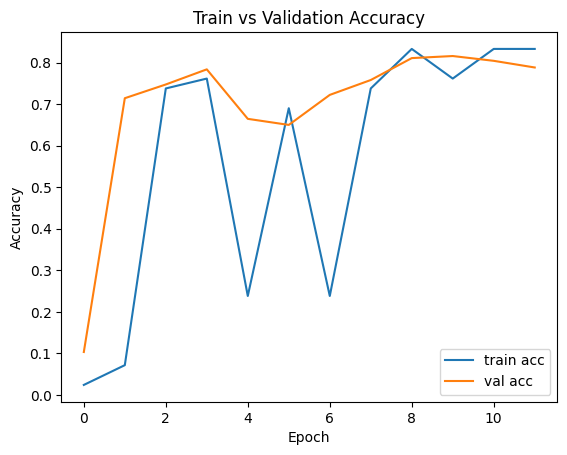

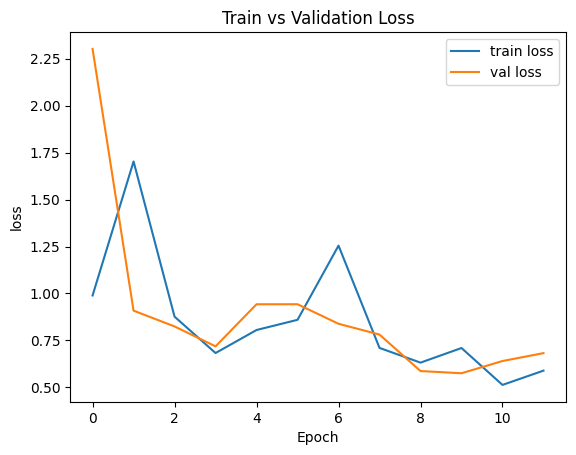

In [55]:

# Go back up and try a few different networks and initialization strategies
# Plot loss if you want
# Plot accuracy
def acc_plotter(train_acc, val_acc):
    plt.plot(np.arange(len(train_acc)),train_acc,label="train acc")
    plt.plot(np.arange(len(val_acc)),val_acc,label="val acc")
    plt.title("Train vs Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

def loss_plotter(train_loss, val_loss):
    plt.plot(np.arange(len(train_loss)),train_loss,label="train loss")
    plt.plot(np.arange(len(val_loss)),val_loss,label="val loss")
    plt.title("Train vs Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
acc_plotter(train_acc_mean,val_acc_mean)
loss_plotter(train_loss,val_loss)


In [2]:
# Compute and print the number of parameters in the model


___

### Part 4
Learn about how convolution layers affect the shape of outputs, and answer the following quiz questions. Include these in a new markdown cell in your jupyter notebook.


*Using a Kernel size of 3×3 what should the settings of your 2d convolution be that results in the following mappings (first answer given to you)*

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(3, 3), padding=(0, 0))
* (c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) : **Your answer in bold here**
* (c=3, h=10, w=10) ⇒ (c=65, h=12, w=12) : **Your answer in bold here**
* (c=3, h=10, w=10) ⇒ (c=7, h=20, w=20) : **Your answer in bold here**

*Using a Kernel size of 5×5:*)

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(5, 5), padding=(1, 1))
* (c=3, h=10, w=10) ⇒ (c=100, h=10, w=10) : **Your answer in bold here**
* (c=3, h=10, w=10) ⇒ (c=23, h=12, w=12) : **Your answer in bold here**
* (c=3, h=10, w=10) ⇒ (c=5, h=24, w=24) : **Your answer in bold here**

*Using Kernel size of 5×3:*

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : **Your answer in bold here**
* (c=3, h=10, w=10) ⇒ (c=100, h=10, w=10) : **Your answer in bold here**
* (c=3, h=10, w=10) ⇒ (c=23, h=12, w=12) : **Your answer in bold here**
* (c=3, h=10, w=10) ⇒ (c=5, h=24, w=24) : **Your answer in bold here**

*Determine the kernel that requires the smallest padding size to make the following mappings possible:*

* (c=3, h=10, w=10) ⇒ (c=10, h=9, w=7) : **Your answer in bold here**
* (c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) : **Your answer in bold here**

**TODO:**

* Answer all the questions above 

**DONE:**


In [1]:
# Write some test code for checking the answers for these problems (example shown in the video)
